In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'
import sys
sys.path.append('../src/')
import h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import pandas as pd
from display.display import get_cmap

In [2]:
mse_file  = '/Users/priyankashinde/Desktop/neurips-2020-sevir-master/models/mse_model_nowcast.h5'
mse_model = tf.keras.models.load_model(mse_file,compile=False,custom_objects={"tf": tf})

In [3]:
from readers.nowcast_reader import read_data
x_test,y_test = read_data('nowcast_testing.h5',end=50)

In [140]:
x_test.shape

(50, 384, 384, 13)

In [10]:
y_pred = []
yp = mse_model.predict(x_test)
y_pred.append(yp)

In [11]:
y_pred

[array([[[[-0.6401992 , -0.5870094 , -0.5101932 , ..., -0.51866573,
           -0.48158854, -0.56901133],
          [-0.67455256, -0.6396818 , -0.5799978 , ..., -0.564787  ,
           -0.5462961 , -0.5311434 ],
          [-0.67805755, -0.65282273, -0.606557  , ..., -0.57290083,
           -0.572192  , -0.5530046 ],
          ...,
          [-0.695789  , -0.69467235, -0.6904702 , ..., -0.68785584,
           -0.6770087 , -0.68206626],
          [-0.6905403 , -0.69023323, -0.6938947 , ..., -0.688236  ,
           -0.6824024 , -0.6821718 ],
          [-0.7050668 , -0.7006483 , -0.69621503, ..., -0.67615426,
           -0.65957546, -0.64316785]],
 
         [[-0.6672849 , -0.6251998 , -0.5644127 , ..., -0.57626987,
           -0.56312466, -0.5635798 ],
          [-0.6735518 , -0.6341304 , -0.5925087 , ..., -0.6017226 ,
           -0.5782716 , -0.56083983],
          [-0.6829772 , -0.64567244, -0.6146455 , ..., -0.595508  ,
           -0.5829775 , -0.56261855],
          ...,
          [-0

In [141]:
y_pred.shape

AttributeError: 'list' object has no attribute 'shape'

In [14]:
count = 0
for i in range(0,12):
    y_pred[i]++
print(count)

1


In [43]:
data = y_pred[0][2]

In [32]:
from PIL import Image

In [36]:
hmf_colors = np.array( [
    [82,82,82], 
    [252,141,89],
    [255,255,191],
    [145,191,219]
])/255

In [44]:
img = Image.fromarray(data, 'RGB')
img.save('my.png')
img.show()

In [105]:
norm = {'scale':47.54,'shift':33.44}
hmf_colors = np.array( [
    [82,82,82], 
    [252,141,89],
    [255,255,191],
    [145,191,219]
])/255

# Model that implements persistence forecast that just repeasts last frame of input
class persistence:
    def predict(self,x_test):
        return np.tile(x_test[:,:,:,-1:],[1,1,1,12])

def plot_hit_miss_fa(ax,y_true,y_pred,thres):
    mask = np.zeros_like(y_true)
    mask[np.logical_and(y_true>=thres,y_pred>=thres)]=4
    mask[np.logical_and(y_true>=thres,y_pred<thres)]=3
    mask[np.logical_and(y_true<thres,y_pred>=thres)]=2
    mask[np.logical_and(y_true<thres,y_pred<thres)]=1
    cmap=ListedColormap(hmf_colors)
    ax.imshow(mask,cmap=cmap)


def visualize_result(models,x_test,y_test,idx,ax,labels):
    fs=10
    cmap_dict = lambda s: {'cmap':get_cmap(s,encoded=True)[0],
                           'norm':get_cmap(s,encoded=True)[1],
                           'vmin':get_cmap(s,encoded=True)[2],
                           'vmax':get_cmap(s,encoded=True)[3]}
    for i in range(1,13,3):
        xt = x_test[idx,:,:,i]*norm['scale']+norm['shift']
        ax[(i-1)//3][0].imshow(xt,**cmap_dict('vil'))
    ax[0][0].set_title('Inputs',fontsize=fs)
    
    pers = persistence().predict(x_test[idx:idx+1])
    pers = pers*norm['scale']+norm['shift']
    x_test = x_test[idx:idx+1]
    y_test = y_test[idx:idx+1]*norm['scale']+norm['shift']
    y_preds=[]
    for i,m in enumerate(models):
        yp = m.predict(x_test)
        if isinstance(yp,(list,)):
            yp=yp[0]
        y_preds.append(yp*norm['scale']+norm['shift'])
        with h5py.File("y_pred.h5", 'w') as data:
            data['pred'] = y_preds[0]
    
    for i in range(0,12,3):
        ax[i//3][2].imshow(y_test[0,:,:,i],**cmap_dict('vil'))
    ax[0][2].set_title('Target',fontsize=fs)
    
    # Plot Persistence
    for i in range(0,12,3):
        plot_hit_miss_fa(ax[i//3][4],y_test[0,:,:,i],pers[0,:,:,i],74)
    ax[0][4].set_title('Persistence\nScores',fontsize=fs)
    
    for k,m in enumerate(models):
        for i in range(0,12,3):
            ax[i//3][5+2*k].imshow(y_preds[k][0,:,:,i],**cmap_dict('vil'))
            plot_hit_miss_fa(ax[i//3][5+2*k+1],y_test[0,:,:,i],y_preds[k][0,:,:,i],74)

        ax[0][5+2*k].set_title(labels[k],fontsize=fs)
        ax[0][5+2*k+1].set_title(labels[k]+'\nScores',fontsize=fs)
        
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            ax[j][i].xaxis.set_ticks([])
            ax[j][i].yaxis.set_ticks([])
    for i in range(4):
        ax[i][1].set_visible(False)
    for i in range(4):
        ax[i][3].set_visible(False)
    ax[0][0].set_ylabel('-45 Minutes')
    ax[1][0].set_ylabel('-30 Minutes')
    ax[2][0].set_ylabel('-15 Minutes')
    ax[3][0].set_ylabel('  0 Minutes')
    ax[0][2].set_ylabel('+15 Minutes')
    ax[1][2].set_ylabel('+30 Minutes')
    ax[2][2].set_ylabel('+45 Minutes')
    ax[3][2].set_ylabel('+60 Minutes')
    
    legend_elements = [Patch(facecolor=hmf_colors[1], edgecolor='k', label='False Alarm'),
                   Patch(facecolor=hmf_colors[2], edgecolor='k', label='Miss'),
                   Patch(facecolor=hmf_colors[3], edgecolor='k', label='Hit')]
    ax[-1][-1].legend(handles=legend_elements, loc='lower right', bbox_to_anchor= (-5.4, -.35), 
                           ncol=5, borderaxespad=0, frameon=False, fontsize='16')
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

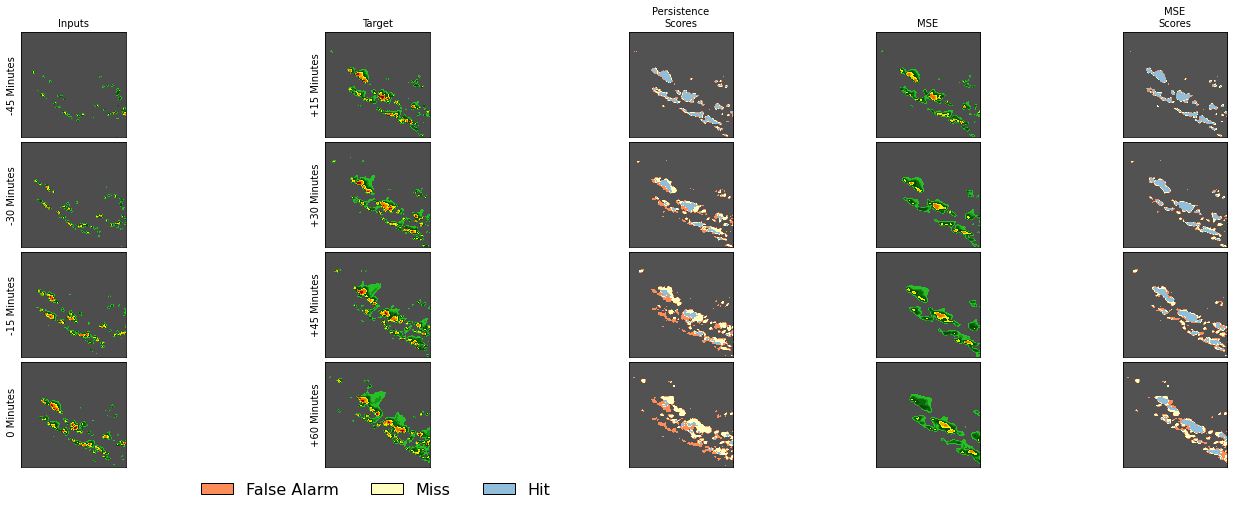

In [106]:
idx=25 # adjust this to pick a case
fig,ax = plt.subplots(4,7,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1]})
visualize_result([mse_model],x_test,y_test,idx,ax,labels=['MSE'])

(384, 384)


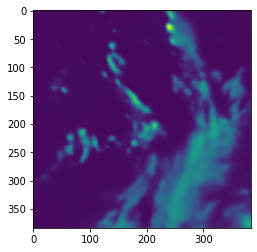

In [143]:
with h5py.File('y_pred.h5','r') as hf:
    plt.imshow(hf['pred'][49][:,:,5])
    print(hf['pred'][49][:,:,5].shape)

In [147]:
norm = {'scale':47.54,'shift':33.44}
hmf_colors = np.array( [
    [82,82,82], 
    [252,141,89],
    [255,255,191],
    [145,191,219]
])/255

# Model that implements persistence forecast that just repeasts last frame of input
class persistence:
    def predict(self,x_test):
        return np.tile(x_test[:,:,:,-1:],[1,1,1,12])

def plot_hit_miss_fa(ax,y_true,y_pred,thres):
    mask = np.zeros_like(y_true)
    mask[np.logical_and(y_true>=thres,y_pred>=thres)]=4
    mask[np.logical_and(y_true>=thres,y_pred<thres)]=3
    mask[np.logical_and(y_true<thres,y_pred>=thres)]=2
    mask[np.logical_and(y_true<thres,y_pred<thres)]=1
    cmap=ListedColormap(hmf_colors)
    ax.imshow(mask,cmap=cmap)


def visualize_result(models,x_test,y_test,idx,ax,labels):
    fs=10
    cmap_dict = lambda s: {'cmap':get_cmap(s,encoded=True)[0],
                           'norm':get_cmap(s,encoded=True)[1],
                           'vmin':get_cmap(s,encoded=True)[2],
                           'vmax':get_cmap(s,encoded=True)[3]}
    for i in range(1,13,3):
        xt = x_test[idx,:,:,i]*norm['scale']+norm['shift']
        ax[(i-1)//3][0].imshow(xt,**cmap_dict('vil'))
    ax[0][0].set_title('Inputs',fontsize=fs)
    
    pers = persistence().predict(x_test[idx:idx+1])
    pers = pers*norm['scale']+norm['shift']
    x_test = x_test[idx:idx+1]
    y_test = y_test[idx:idx+1]*norm['scale']+norm['shift']
    y_preds=[]
    for i,m in enumerate(models):
        yp = m.predict(x_test)
        if isinstance(yp,(list,)):
            yp=yp[0]
        y_preds.append(yp*norm['scale']+norm['shift'])
        with h5py.File("y_pred1.h5", 'w') as data:
            data['pred'] = y_preds[0]


In [148]:
idx=1 # adjust this to pick a case
#fig,ax = plt.subplots(4,7,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1]})
visualize_result([mse_model],x_test,y_test,idx,ax,labels=['MSE'])

(384, 384)


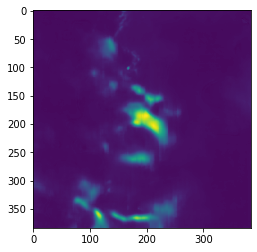

In [149]:
with h5py.File('y_pred1.h5','r') as hf:
    plt.imshow(hf['pred'][0][:,:,11])
    print(hf['pred'][0][:,:,11].shape)

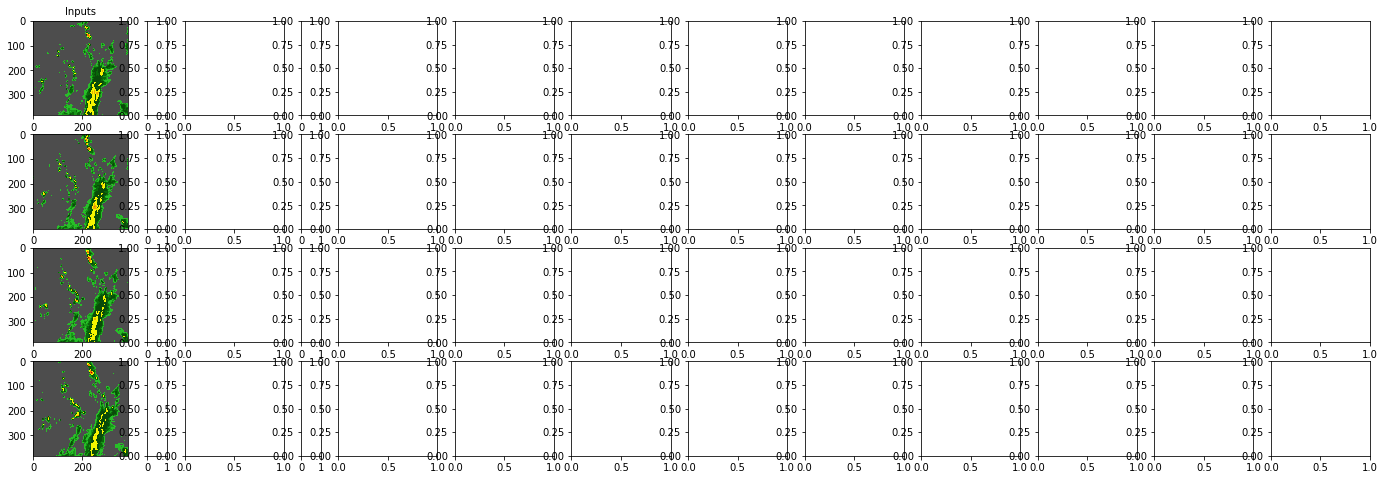

In [125]:
idx=49 # adjust this to pick a case
fig,ax = plt.subplots(4,13,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1,1,1,1,1,1,1]})
visualize_result([mse_model],x_test,y_test,idx,ax,labels=['MSE'])